In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

class CustomMAE(nn.Module):
    def __init__(self, img_size=64, patch_size=8, embed_dim=512, num_heads=8, depth=6):
        super(CustomMAE, self).__init__()

        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.embed_dim = embed_dim

        # Patch embedding (Linear Projection + Positional Encoding)
        self.patch_embed = nn.Conv2d(1, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches, embed_dim))

        # Transformer Encoder (Inspired by ViT)
        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=1024, dropout=0.1),
            num_layers=depth
        )

        # Fully connected layer to reshape encoded features for decoding
        # self.fc = nn.Linear(embed_dim, embed_dim * (patch_size // 2) * (patch_size // 2))

        # Decoder with Up-Convolutions
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(embed_dim, 256, kernel_size=4, stride=2, padding=1),  # 8x8 → 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 16x16 → 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 32x32 → 64x64
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1)  # Output: 64x64
        )

    def forward(self, x):
        B, C, H, W = x.shape  # Bx1x64x64
        patches = self.patch_embed(x).flatten(2).transpose(1, 2)  # Convert to patches
        patches = patches + self.pos_embed  # Add positional embeddings
        
        # masked_patches = patches * mask.unsqueeze(-1)  # Apply mask

        encoded = self.encoder(patches)  # Transformer encoding
        # print(encoded.shape)

        # Reshape for decoder
        # encoded = self.fc(encoded)  # Fully connected to reshape embedding
        encoded = encoded.view(B, self.embed_dim, H // self.patch_size, W // self.patch_size)

        # Decode using up-convolutions
        reconstructed_img = self.decoder(encoded)

        return reconstructed_img


In [4]:
from kaggle_secrets import UserSecretsClient
import wandb

user_secrets = UserSecretsClient()

my_secret = user_secrets.get_secret("wandb_api_key") 

wandb.login(key=my_secret)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


wandb: Currently logged in as: pechetti-1. Use `wandb login --relogin` to force relogin


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader

class MAEClassifier(nn.Module):
    def __init__(self, pretrained_mae, num_classes=3):
        super(MAEClassifier, self).__init__()

        self.encoder = pretrained_mae.patch_embed  # Use the same patch embedding
        self.pos_embed = pretrained_mae.pos_embed
        self.transformer = pretrained_mae.encoder  # Use the pre-trained transformer

        embed_dim = pretrained_mae.embed_dim
        num_patches = pretrained_mae.num_patches

        # Classification head
        self.cls_head = nn.Sequential(
            nn.Linear(embed_dim, 256),
            nn.ReLU(),
            nn.Linear(256,128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64,10),
            nn.ReLU(),
            nn.Linear(10, num_classes)
        )

    def forward(self, x):
        B, C, H, W = x.shape  # Bx1x64x64

        # Convert image to patches
        patches = self.encoder(x).flatten(2).transpose(1, 2)  # Convert to patch embeddings
        patches = patches + self.pos_embed  # Add positional embeddings

        # Transformer encoding
        encoded = self.transformer(patches)  # B x num_patches x embed_dim

        # Global average pooling over patches
        encoded = encoded.mean(dim=1)  # B x embed_dim

        # Classification head
        logits = self.cls_head(encoded)  # B x num_classes
        return logits


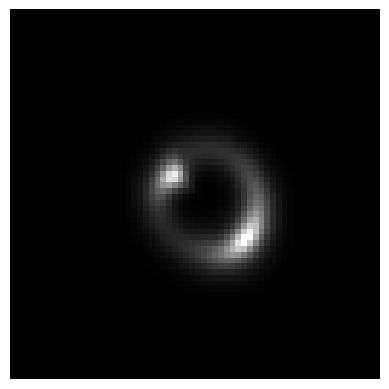

In [8]:
import os
import numpy as np
import torch
import torchvision.transforms as transforms
import cv2
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

class StrongLensingDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (str): Path to the dataset directory.
            transform (callable, optional): Transform to apply to images.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ["axion", "no_sub", "cdm"]
        self.data = []

        # Load file paths and labels
        for class_idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            for file_name in os.listdir(class_dir):
                file_path = os.path.join(class_dir, file_name)
                self.data.append((file_path, class_idx))  # Store (file_path, label)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        file_path, label = self.data[idx]
        image = np.load(file_path,allow_pickle=True)  # Load .npy file
        if image.ndim!=2:
            image=image[0]
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # Add channel dimension
        
        if self.transform:
            image = self.transform(image)

        return image, label

# Initialize dataset
dataset = StrongLensingDataset(root_dir='/kaggle/input/foundational-model-task-ml4sci/Task4/Dataset')

# Load a sample from dataset
sample_img, sample_label = dataset[0]
plt.imshow(sample_img.squeeze(), cmap='gray')
plt.axis("off")
plt.show()


In [9]:
import wandb

# Initialize wandb
wandb.init(project="MAE-Finetuning", name="classification_finetune")

wandb: Tracking run with wandb version 0.19.1


wandb: Run data is saved locally in /kaggle/working/wandb/run-20250327_230724-k9hx8yfv
wandb: Run `wandb offline` to turn off syncing.


wandb: Syncing run classification_finetune


wandb: ⭐️ View project at https://wandb.ai/pechetti-1/MAE-Finetuning


wandb: 🚀 View run at https://wandb.ai/pechetti-1/MAE-Finetuning/runs/k9hx8yfv


In [10]:
from torch.utils.data import random_split, DataLoader


# Define transformation
transform = transforms.Compose([
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Load dataset
dataset = StrongLensingDataset("/kaggle/input/foundational-model-task-ml4sci/Task4/Dataset", transform=transform)


# Train/Validation Split (90:10)
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [11]:
# Load Pretrained MAE
pretrained_mae = CustomMAE()  # Load pre-trained weights if available
pretrained_mae.load_state_dict(torch.load("/kaggle/input/pretrained-mae/pytorch/default/1/pretrainedmae_epoch10.pth"))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
<ipython-input-11-bc38018e003e>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you sta

<All keys matched successfully>

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_mae.to(device)


# Initialize classifier model
model = MAEClassifier(pretrained_mae).to(device)

for param in model.encoder.parameters():
    param.requires_grad = False
for param in model.transformer.parameters():
    param.requires_grad = False

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# Training loop with validation
epochs = 50
for epoch in range(epochs):

    if epoch == 10:  # Unfreeze encoder after 5 epochs
        for param in model.encoder.parameters():
            param.requires_grad = True
        for param in model.transformer.parameters():
            param.requires_grad = True
        print("Encoder Unfrozen!")
        
    model.train()
    total_train_loss, total_train_correct = 0.0, 0
    total_val_loss, total_val_correct = 0.0, 0

    # Training Phase
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        total_train_correct += (logits.argmax(dim=1) == labels).sum().item()

    # Validation Phase
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            logits = model(images)
            loss = criterion(logits, labels)

            total_val_loss += loss.item()
            total_val_correct += (logits.argmax(dim=1) == labels).sum().item()

    # Compute Metrics
    train_loss = total_train_loss / len(train_loader)
    train_acc = total_train_correct / len(train_dataset)
    val_loss = total_val_loss / len(val_loader)
    val_acc = total_val_correct / len(val_dataset)

    # Log to wandb
    wandb.log({
        "Train Loss": train_loss,
        "Train Accuracy": train_acc,
        "Validation Loss": val_loss,
        "Validation Accuracy": val_acc
    })

    print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    if (epoch + 1) % 2 == 0:
        torch.save(model.state_dict(), f"classifer_epoch{epoch+1}.pth")

print("Fine-tuning complete!")
wandb.finish()


Epoch [1/50] | Train Loss: 1.0987 | Train Acc: 0.3334 | Val Loss: 1.0991 | Val Acc: 0.3269


Epoch [2/50] | Train Loss: 1.0983 | Train Acc: 0.3404 | Val Loss: 1.0996 | Val Acc: 0.3350


Epoch [3/50] | Train Loss: 1.0966 | Train Acc: 0.3570 | Val Loss: 1.0954 | Val Acc: 0.3542


Epoch [4/50] | Train Loss: 1.0945 | Train Acc: 0.3639 | Val Loss: 1.0953 | Val Acc: 0.3605


Epoch [5/50] | Train Loss: 1.0930 | Train Acc: 0.3693 | Val Loss: 1.0927 | Val Acc: 0.3741


Epoch [6/50] | Train Loss: 1.0914 | Train Acc: 0.3749 | Val Loss: 1.0910 | Val Acc: 0.3781


Epoch [7/50] | Train Loss: 1.0889 | Train Acc: 0.3767 | Val Loss: 1.0882 | Val Acc: 0.3805


Epoch [8/50] | Train Loss: 1.0844 | Train Acc: 0.3841 | Val Loss: 1.0822 | Val Acc: 0.3883


Epoch [9/50] | Train Loss: 1.0803 | Train Acc: 0.3917 | Val Loss: 1.0852 | Val Acc: 0.3850


Epoch [10/50] | Train Loss: 1.0751 | Train Acc: 0.3978 | Val Loss: 1.0710 | Val Acc: 0.4062
Encoder Unfrozen!


Epoch [11/50] | Train Loss: 1.0697 | Train Acc: 0.4058 | Val Loss: 0.9338 | Val Acc: 0.5729


Epoch [12/50] | Train Loss: 0.7831 | Train Acc: 0.6375 | Val Loss: 0.5773 | Val Acc: 0.7568


Epoch [13/50] | Train Loss: 0.5795 | Train Acc: 0.7543 | Val Loss: 0.6419 | Val Acc: 0.7263


Epoch [14/50] | Train Loss: 0.5427 | Train Acc: 0.7700 | Val Loss: 0.4524 | Val Acc: 0.8253


Epoch [15/50] | Train Loss: 0.5001 | Train Acc: 0.7934 | Val Loss: 0.4053 | Val Acc: 0.8433


Epoch [16/50] | Train Loss: 0.4767 | Train Acc: 0.8036 | Val Loss: 0.4060 | Val Acc: 0.8401


Epoch [17/50] | Train Loss: 0.5020 | Train Acc: 0.7951 | Val Loss: 0.4689 | Val Acc: 0.8110


Epoch [18/50] | Train Loss: 0.4534 | Train Acc: 0.8134 | Val Loss: 0.4250 | Val Acc: 0.8300


Epoch [19/50] | Train Loss: 0.4478 | Train Acc: 0.8160 | Val Loss: 0.4362 | Val Acc: 0.8241


Epoch [20/50] | Train Loss: 0.4388 | Train Acc: 0.8249 | Val Loss: 0.5519 | Val Acc: 0.7359


Epoch [21/50] | Train Loss: 0.4470 | Train Acc: 0.8287 | Val Loss: 0.4413 | Val Acc: 0.8234


Epoch [22/50] | Train Loss: 0.4232 | Train Acc: 0.8290 | Val Loss: 0.4209 | Val Acc: 0.8286


Epoch [23/50] | Train Loss: 0.4331 | Train Acc: 0.8307 | Val Loss: 0.4754 | Val Acc: 0.8081


Epoch [24/50] | Train Loss: 0.4397 | Train Acc: 0.8226 | Val Loss: 0.4147 | Val Acc: 0.8414


Epoch [25/50] | Train Loss: 1.0065 | Train Acc: 0.4214 | Val Loss: 1.0987 | Val Acc: 0.3269


Epoch [26/50] | Train Loss: 1.0987 | Train Acc: 0.3310 | Val Loss: 1.0986 | Val Acc: 0.3392


Epoch [27/50] | Train Loss: 1.0987 | Train Acc: 0.3358 | Val Loss: 1.0987 | Val Acc: 0.3392


Epoch [28/50] | Train Loss: 1.0483 | Train Acc: 0.4037 | Val Loss: 0.9339 | Val Acc: 0.5133


Epoch [29/50] | Train Loss: 0.6131 | Train Acc: 0.7417 | Val Loss: 0.5185 | Val Acc: 0.7935


Epoch [30/50] | Train Loss: 0.5151 | Train Acc: 0.7912 | Val Loss: 0.4851 | Val Acc: 0.7898


Epoch [31/50] | Train Loss: 0.4620 | Train Acc: 0.8135 | Val Loss: 0.5297 | Val Acc: 0.7908


Epoch [32/50] | Train Loss: 0.5174 | Train Acc: 0.7879 | Val Loss: 0.4448 | Val Acc: 0.8174


Epoch [33/50] | Train Loss: 0.4500 | Train Acc: 0.8189 | Val Loss: 0.4215 | Val Acc: 0.8323


Epoch [34/50] | Train Loss: 0.4357 | Train Acc: 0.8252 | Val Loss: 0.4093 | Val Acc: 0.8367


Epoch [35/50] | Train Loss: 0.4266 | Train Acc: 0.8272 | Val Loss: 0.3639 | Val Acc: 0.8537


Epoch [36/50] | Train Loss: 0.4209 | Train Acc: 0.8331 | Val Loss: 0.4805 | Val Acc: 0.8112


Epoch [37/50] | Train Loss: 0.4339 | Train Acc: 0.8262 | Val Loss: 0.3880 | Val Acc: 0.8478


Epoch [38/50] | Train Loss: 0.4091 | Train Acc: 0.8355 | Val Loss: 0.3512 | Val Acc: 0.8593


Epoch [39/50] | Train Loss: 0.4064 | Train Acc: 0.8357 | Val Loss: 0.3924 | Val Acc: 0.8477


Epoch [40/50] | Train Loss: 0.3950 | Train Acc: 0.8387 | Val Loss: 0.3609 | Val Acc: 0.8565


Epoch [41/50] | Train Loss: 0.3979 | Train Acc: 0.8387 | Val Loss: 0.3604 | Val Acc: 0.8525


Epoch [42/50] | Train Loss: 0.3964 | Train Acc: 0.8405 | Val Loss: 0.4454 | Val Acc: 0.8170


Epoch [43/50] | Train Loss: 0.4231 | Train Acc: 0.8280 | Val Loss: 0.3625 | Val Acc: 0.8528


Epoch [44/50] | Train Loss: 0.3794 | Train Acc: 0.8486 | Val Loss: 0.3866 | Val Acc: 0.8436


Epoch [45/50] | Train Loss: 0.3863 | Train Acc: 0.8442 | Val Loss: 0.4230 | Val Acc: 0.8298


Epoch [46/50] | Train Loss: 0.3799 | Train Acc: 0.8472 | Val Loss: 0.5938 | Val Acc: 0.7742
